In [9]:
import sys
sys.path.append("..")

from utils.pickleloader import load_pickle, dump_pickle
import utils.fdt as fdt
import utils.mhue as mhue
import utils.homogeneity as homogeneity
import utils.stability as stability
import utils.match_groundtruth as match_groundtruth
import utils.region as region

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import distance_transform_cdt
def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
#     print((x1,x2),(y1,y2))
    return image[x1:x2, y1:y2]

In [1]:
importlib.reload(region)

NameError: name 'importlib' is not defined

In [6]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [10]:
def run(img_idx):
    # Masking parameter
    beta = 10
    
    result = {}
    path = '../image/t1/'
    filenames = ['outImg' + str(idx) + '.bmp' for idx in img_idx]
    img_org_lst = [cv.imread(path+filename,0) for filename in filenames]
    truth_img_lst = [cv.imread('../image/groundtruth/('+str(idx)+').bmp',0) for idx in img_idx]
    
    # get best threshold
    best_t = match_groundtruth.get_best_t(img_org_lst,img_idx,truth_img_lst)
    
    # Mask and crop the image
    img_lst = []
    scharr_lst = []
    for img in img_org_lst:
        _,mask = cv.threshold(img,beta,255,0)
        mask = binary_fill_holes(mask)
        img = img*mask
        img = crop_image(img)
        scharr = homogeneity.get_scharr(img)
        scharr = homogeneity.rank_normalize(scharr)
        scharr_lst.append(scharr)
        img_lst.append(img)
    
    # Calculate bdt
    print('======================================')
    print('Calculate BDT')
    print('======================================')
    img_bdts_o = []
    img_bdts_b = []
    for lst_idx,img in enumerate(img_lst):
        idx = img_idx[lst_idx]
        pickle_name_o = "../pickle/bdts_o"+str(idx)+".pkl"
        pickle_name_b = "../pickle/bdts_b"+str(idx)+".pkl"
        if os.path.exists(pickle_name_o):
            print('Index: {}, Pickle files found. BDT loaded from pickle.'.format(str(idx)))
            img_bdts_o.append(np.array(load_pickle(pickle_name_o)))
            img_bdts_b.append(np.array(load_pickle(pickle_name_b)))
        else:
            print('Index: {}, Calculating BDT...'.format(str(idx)))
            image = img_lst[lst_idx]
            inten_min = np.min(image)
            inten_max = np.max(image)
            n_pixels = np.size(image)
            t1 = inten_min + 2
            t2 = inten_max - 2
            bdts_o = []
            bdts_b = []
            for t in range(t1, t2):
                # object
                _, src = cv.threshold(image, t, 255, cv.THRESH_BINARY)
#                 transformer = fdt.FDT(src)
#                 bdt_o = transformer.cal_fdt(fdt=False,uint8=False)
                bdt_o = distance_transform_cdt(src,return_distances=True)
                bdts_o.append(bdt_o)
                # background
                src = 255-src
#                 transformer = fdt.FDT(src)
#                 bdt_b = transformer.cal_fdt(fdt=False,uint8=False)
                bdt_b = distance_transform_cdt(src,return_distances=True)
                bdts_b.append(bdt_b)
            # cache the bdt
            dump_pickle(pickle_name_o,bdts_o)
            dump_pickle(pickle_name_b,bdts_b)
            print('Index: {}, done. Pickle files saved.'.format(str(idx)))
            img_bdts_o.append(np.array(bdts_o))
            img_bdts_b.append(np.array(bdts_b))
    
    # original MHUE method
    print('======================================')
    print('Original MHUE method')
    print('======================================')
    uncertainty_lst = []
    mhue_lst = []
    mhue_t = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/uncertainty"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            uncertainty = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Uncertainty loaded.'.format(str(img_idx[idx])))
        else:
            uncertainty = mhue.get_uncertainty(img)
            # cache Uncertainty
            dump_pickle(pickle_name,uncertainty)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        
        uncertainty_lst.append(uncertainty)
        # homogeneity
        scharr = scharr_lst[idx]
        mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr)
        mhue_img = list(map(lambda x:np.sum(x), mhue_img))
        mhue_mint = np.argmin(mhue_img) + np.min(img) + 2
        print('Index: {}, MHUE threshold at: {}.'.format(img_idx[idx], mhue_mint))
        mhue_lst.append(mhue_img)
        mhue_t.append(mhue_mint)
        
    # Stability
    print('======================================')
    print('Calculate EMA-stability metric')
    print('======================================')
    stab_lst = []
    stabema_lst = []
    for idx,img in enumerate(img_lst):
        bdt_o = img_bdts_o[idx]
        pickle_name = "../pickle/stab"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            stab = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Stability metric loaded.'.format(str(img_idx[idx])))
        else:
            stab = stability.get_stability(img,bdt_o)
            # cache the stab metric
            dump_pickle(pickle_name,stab)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        stab_lst.append(stab)
        stab = stability.pix_scale(stab,bdt_o)
        stab = stability.get_emastab(stab,10)
        stabema_lst.append(stab)
    
    # Minority-Majority ratio
#     print('======================================')
#     print('Calculate Minority-Majority ratio')
#     print('======================================')
#     minomajo_lst = []
#     possible_t_lst = []
#     alpha = 0.1
#     print('!!!Setting object minimum ratio: {}'.format(alpha))
#     for idx,img in enumerate(img_lst):
#         minomajo = mhue.get_minomajo_ratio(img)
#         minomajo_lst.append(minomajo)
#         tmp = np.where(minomajo < alpha)[0]
#         possible_t_idx = np.where(tmp[1:]-tmp[:-1] != 1)[0]
#         possible_t = [tmp[possible_t_idx][0], tmp[possible_t_idx+1][0]]
#         possible_t_lst.append(possible_t)
#         print('Index: {}, possible threshold between {} and {}.'.format(img_idx[idx],possible_t[0],possible_t[1]))
    
    # Weighted uncertainty
    print('======================================')
    print('Calculate Weighted uncertainty')
    print('======================================')
    uncertaintyw_lst = []
    uncertaintyw_t = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/uncertaintyw"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            uncertaintyw = load_pickle(pickle_name)
            uncertaintyw_lst.append(uncertaintyw)
            print('Index: {}, pickle files found. Weighted-uncertainty loaded.'.format(str(img_idx[idx])))
        else:
            uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                                bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=21,sigma=0.3)

            # cache the Weighted uncertainty
            dump_pickle(pickle_name,uncertaintyw)
            uncertaintyw_lst.append(uncertaintyw)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        
#         uncertaintyw = list(map(lambda x:np.sum(x), uncertaintyw))
#         uncertaintyw_mint = np.argmin(uncertaintyw) + np.min(img) + 2
#         print('Index: {}, Weighted-uncertainty threshold at: {}.'.format(img_idx[idx], uncertaintyw_mint))
#         possible_t = possible_t_lst[idx]
#         uncertaintyw_mint = np.argmin(uncertaintyw[possible_t[0]:possible_t[1]]) + np.min(img) + 2 + possible_t[0]
#         print('Index: {}, If truncated, Weighted-uncertainty threshold at: {}.'.format(img_idx[idx], uncertaintyw_mint))
#         uncertaintyw_t.append(uncertaintyw_mint)
    
    # Weighted MHUE
    print('======================================')
    print('Calculate Weighted MHUE')
    print('======================================')
    mhuew_lst = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = uncertaintyw_lst[idx]
        scharr = scharr_lst[idx]
        mhuew_i = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr)
        mhuew_lst.append(mhuew_i)
        print('Index: {}, done.'.format(img_idx[idx]))
#         trange = possible_t_lst[idx]
#         best_mhuew_t = np.argmin(list(map(lambda x:np.sum(x),mhuew_i))[trange[0]:trange[1]]) + np.min(img) + 2 + trange[0]
#         print('Index: {}, If truncated, Weighted-MHUE threshold at: {}.'.format(img_idx[idx], best_mhuew_t))
    
    # New region methods
    print('======================================')
    print('Calculate Weighted Region score')
    print('======================================')
    regions = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/region"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            region_i = load_pickle(pickle_name)
#             plt.plot(list(map(lambda x:np.mean(x),region_i)))
            print('Index: {}, pickle files found. Region score loaded.'.format(str(img_idx[idx])))
        else:
            uncertaintyw = uncertaintyw_lst[idx]
            scharr = scharr_lst[idx]
            region_i = region.get_score(img,uncertainty=uncertaintyw,homogeneity=scharr,kernel_size=7)
            dump_pickle(pickle_name,region_i)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        regions.append(region_i)
        best_region_t = np.argmax(list(map(lambda x:np.mean(x),region_i))) + np.min(img) + 2
        print('Index: {}, Region score threshold at: {}.'.format(img_idx[idx], best_region_t))
    
    # return dict
    result['bdts_o'] = img_bdts_o
    result['bdts_b'] = img_bdts_b
    result['mhue'] = mhue_lst
    result['stab'] = stab_lst
    result['stabema'] = stabema_lst
#     result['minomajo'] = minomajo_lst
#     result['possible_t'] = possible_t
    result['uncertaintyw'] = uncertaintyw_lst
    result['uncertainty'] = uncertainty_lst
    result['mhuew'] = mhuew_lst
    result['img'] = img_lst
    result['truth'] = truth_img_lst
    result['bestt'] = best_t
    result['regions'] = regions
    
    return result

In [11]:
test_lst = [5,14,21,30,47,60,74,83,95,106,112,125]
# test_lst = [5]
res = run(test_lst)

Finding best threshold by error rate
Index: 5, done. Best threshold at: 54
Index: 14, done. Best threshold at: 58
Index: 21, done. Best threshold at: 57
Index: 30, done. Best threshold at: 59
Index: 47, done. Best threshold at: 62
Index: 60, done. Best threshold at: 62
Index: 74, done. Best threshold at: 64
Index: 83, done. Best threshold at: 64
Index: 95, done. Best threshold at: 62
Index: 106, done. Best threshold at: 68
Index: 112, done. Best threshold at: 67
Index: 125, done. Best threshold at: 68
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Calculate BDT
Index: 5, Pickle files found. BDT loaded from pickle.
Index: 14, Pickle files found

In [12]:
_groundtruth = [cv.imread('../image/groundtruth/('+str(idx)+').bmp',0) for idx in test_lst]

In [13]:
_uncertainty = res['uncertainty']
_img = res['img']
_stab = res['stab']
_mhue = res['mhue']
_mhuew = res['mhuew']
# _minomajo = res['minomajo']
_uncertaintyw = res['uncertaintyw']
_stabema = res['stabema']
_best_t = res['bestt']
_region = res['regions']

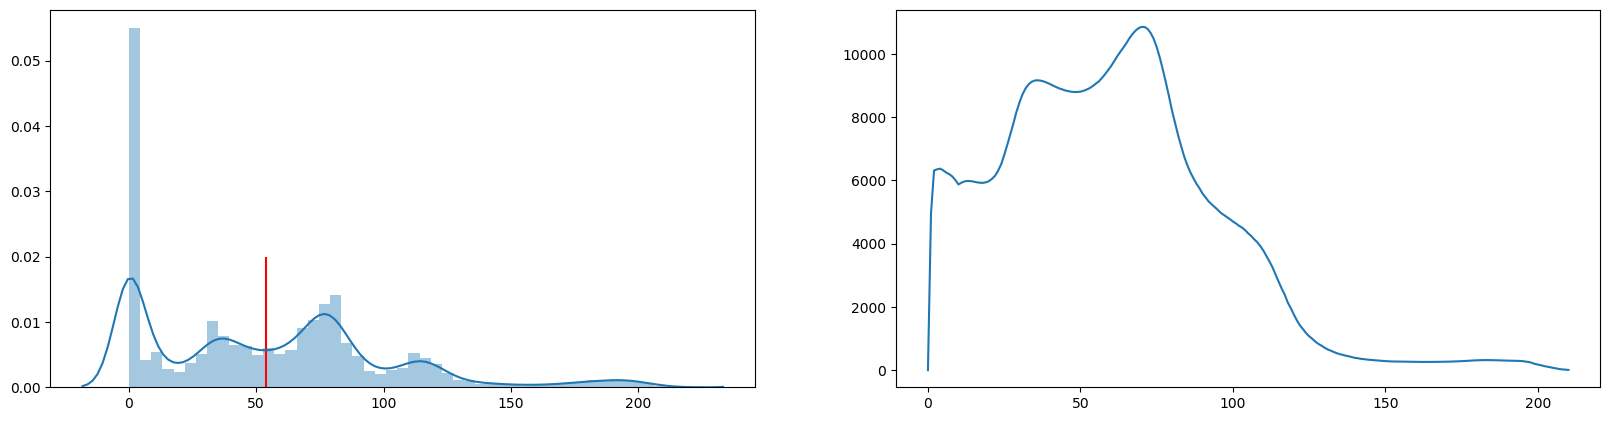

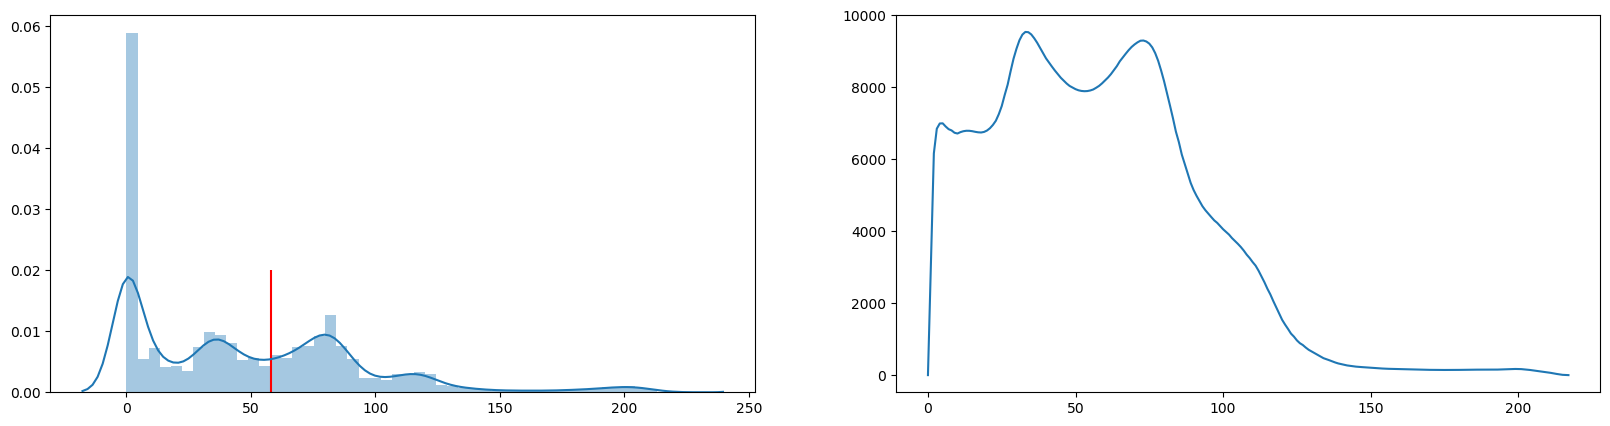

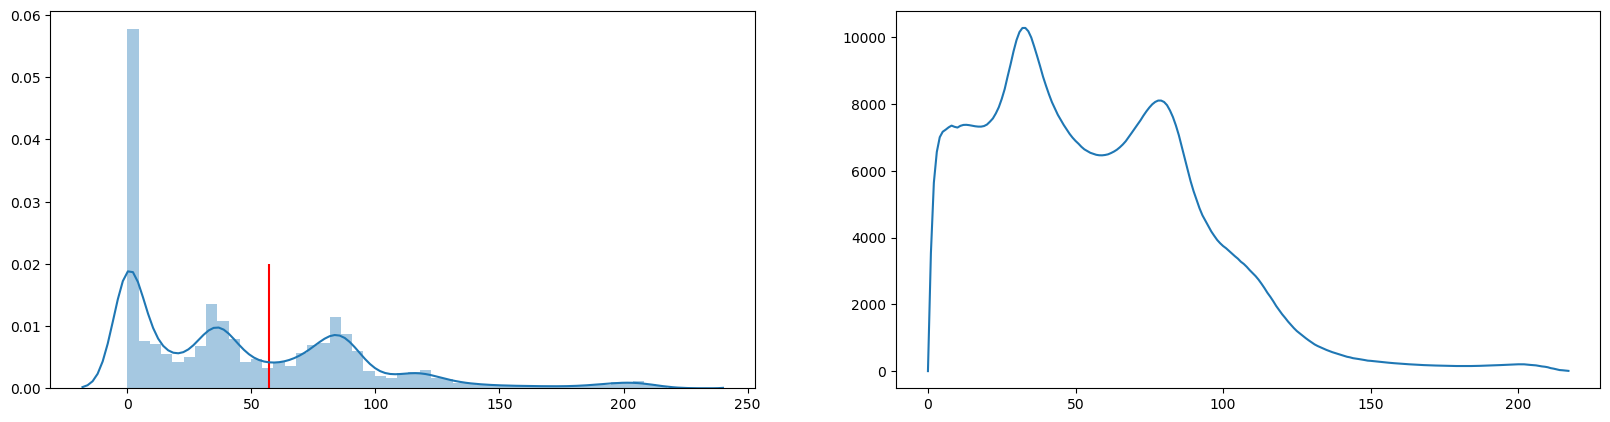

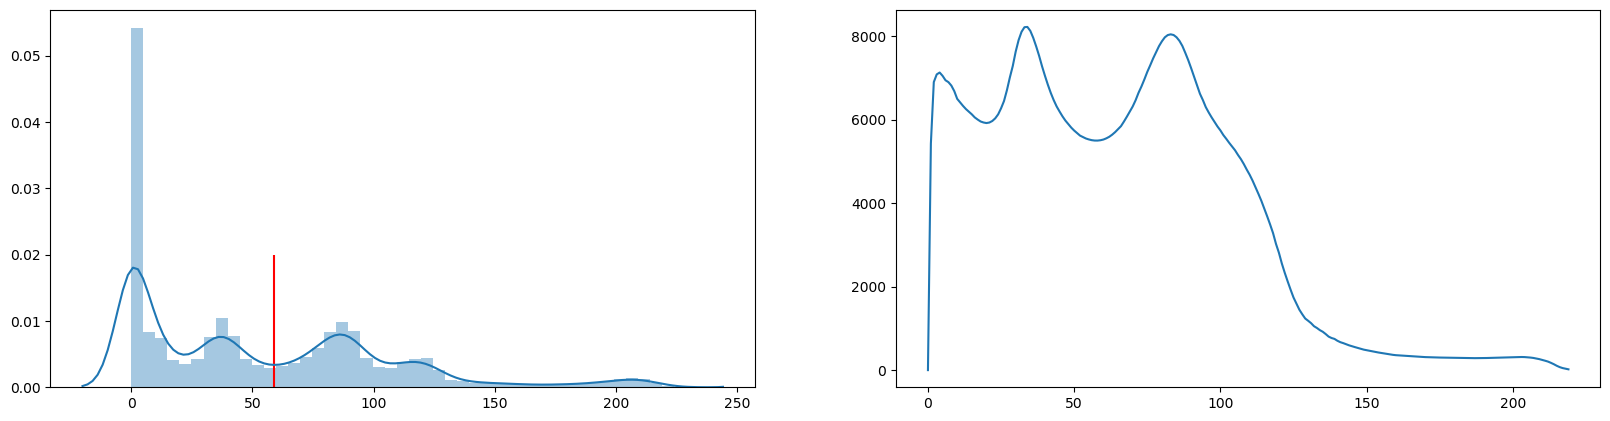

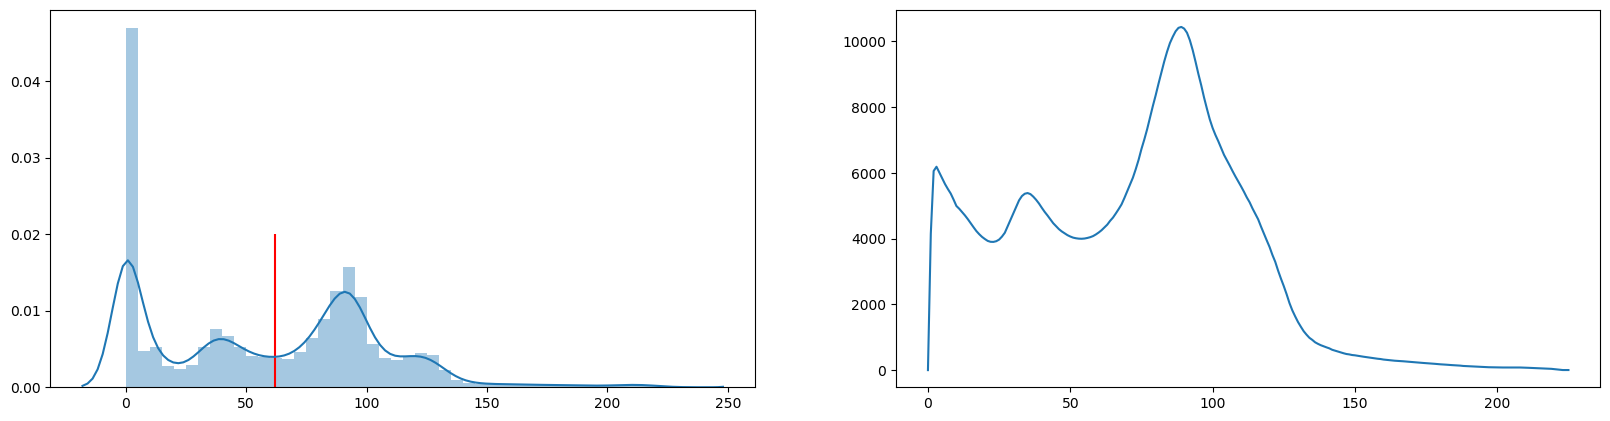

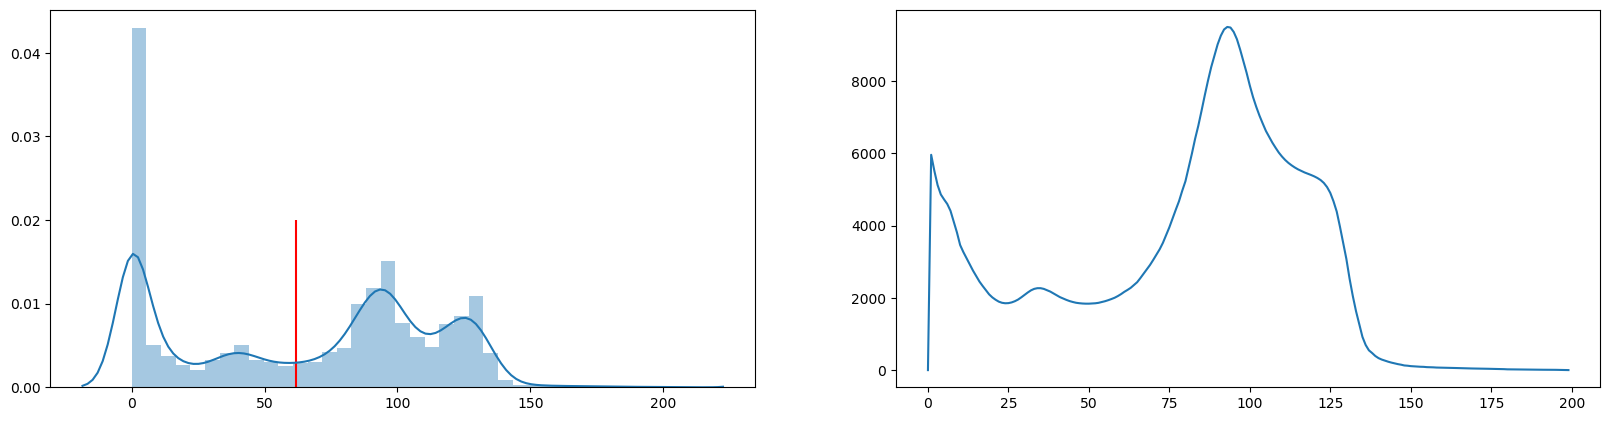

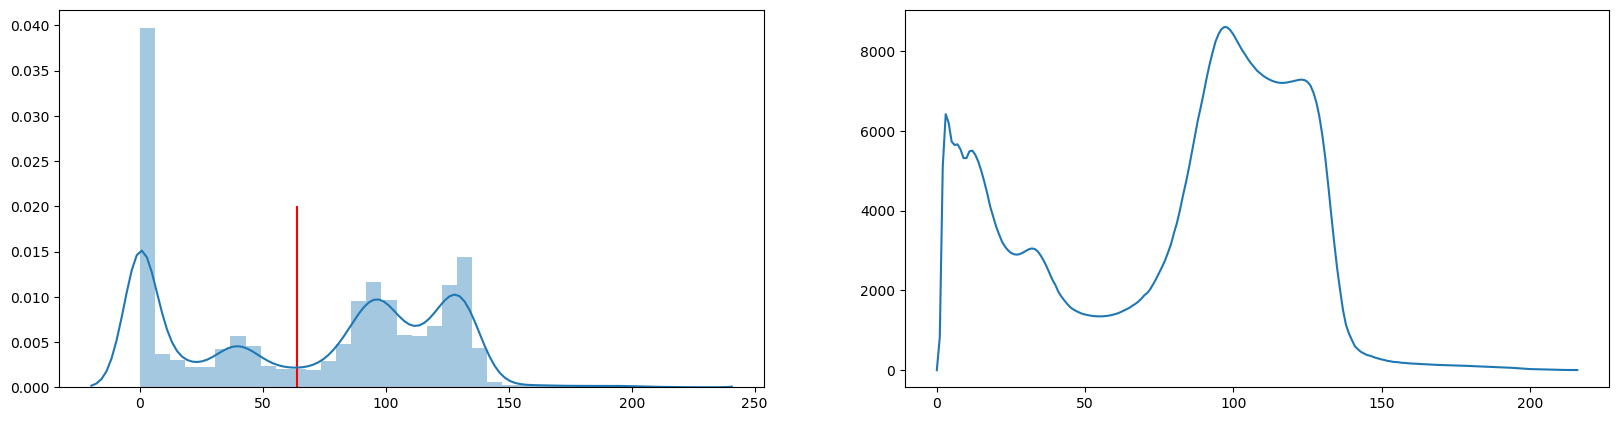

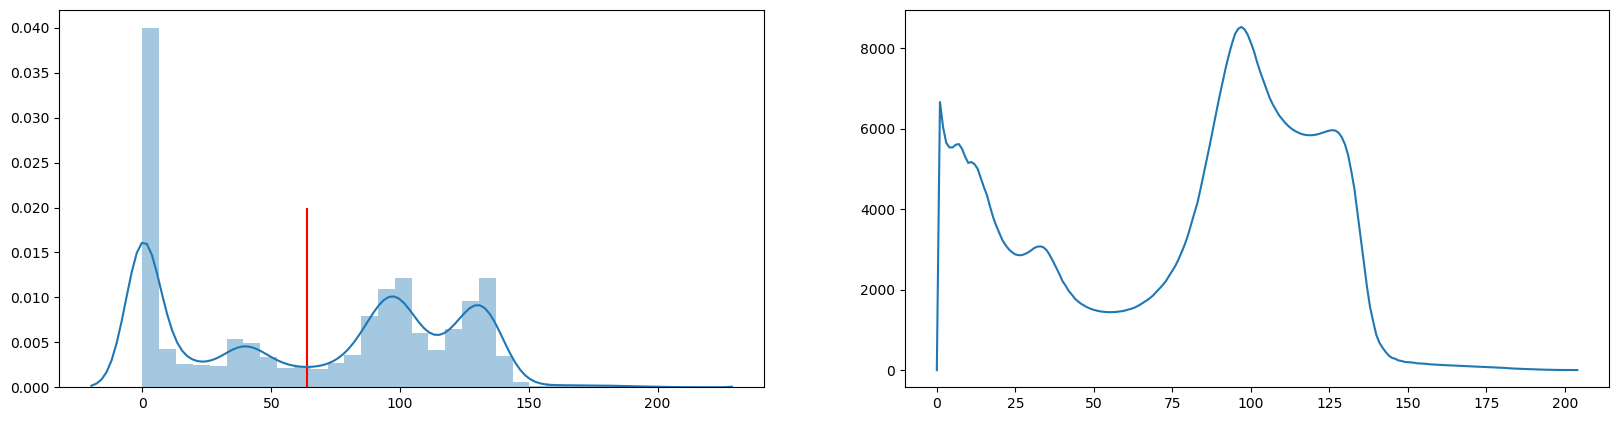

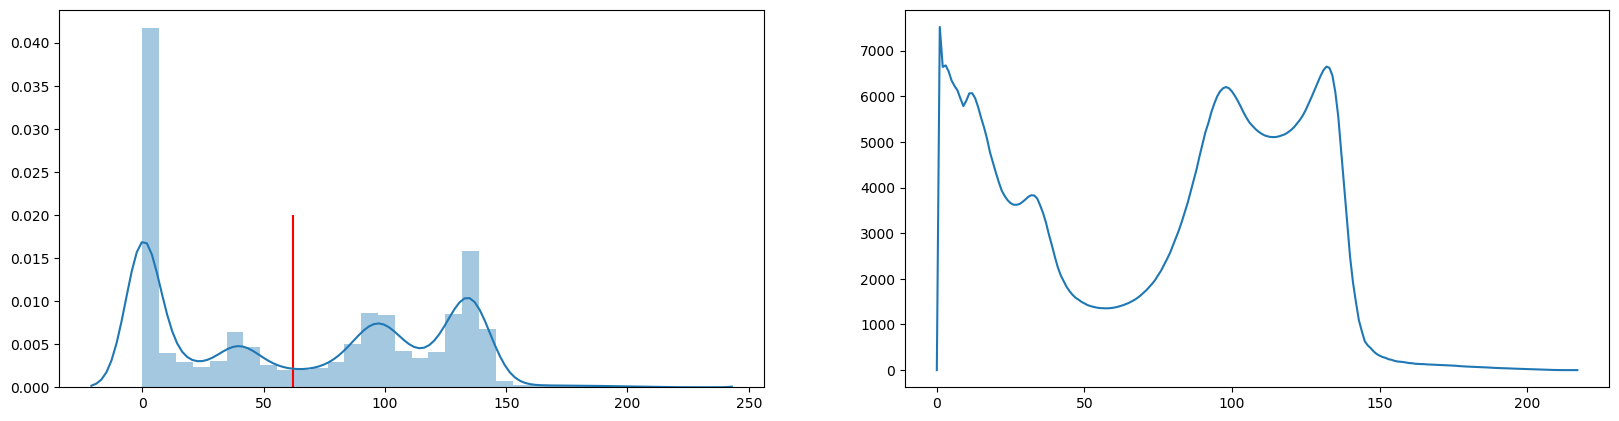

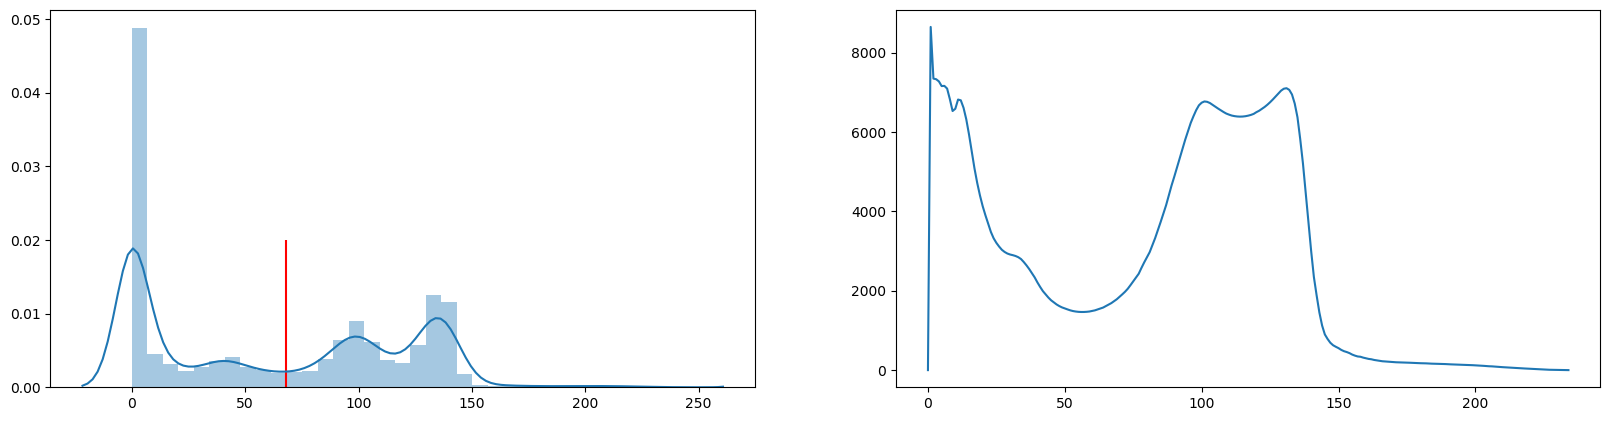

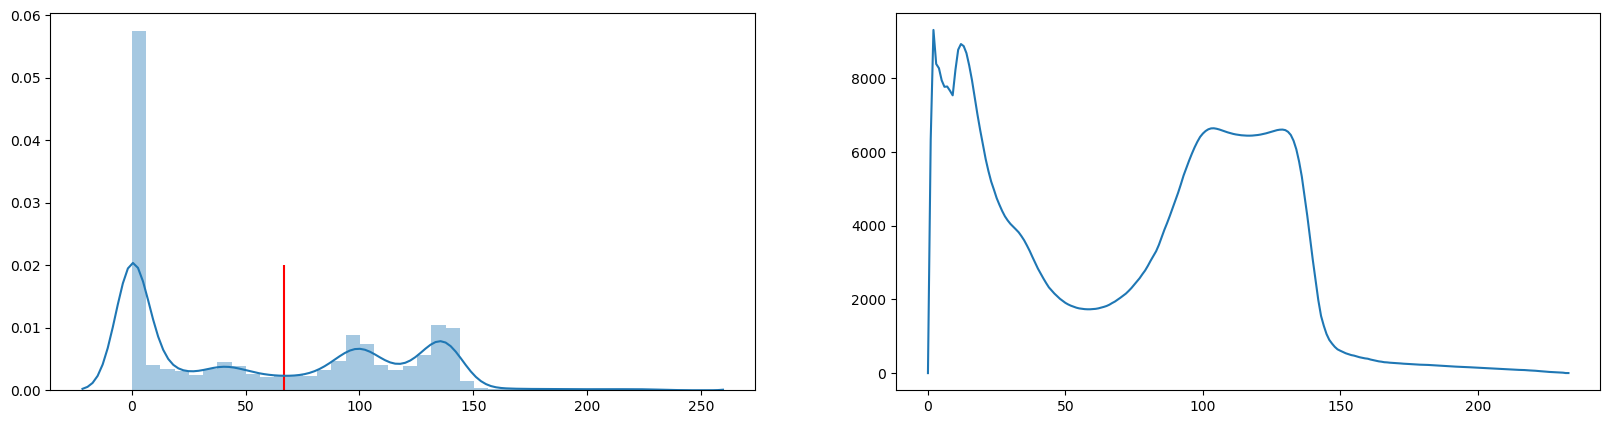

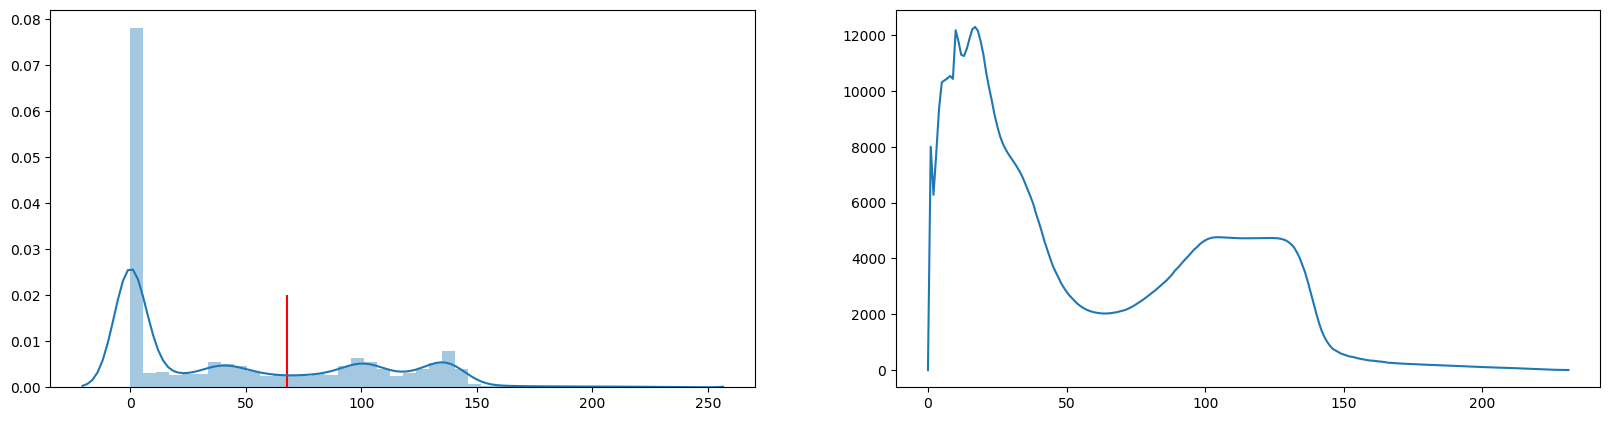

In [14]:
for i in range(len(_img)):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    sns.distplot(_img[i])
    plt.vlines(_best_t[i], 0,  0.02, colors = "r")
    plt.subplot(122)
    plt.plot(list(map(lambda x:np.sum(x),_uncertainty[i])))

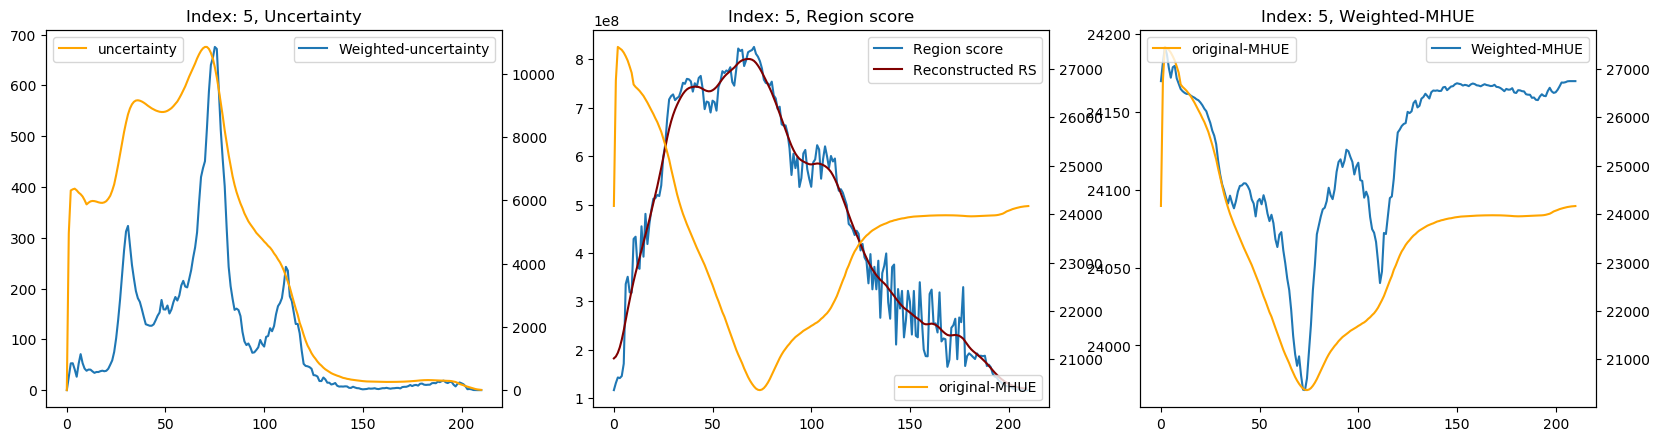

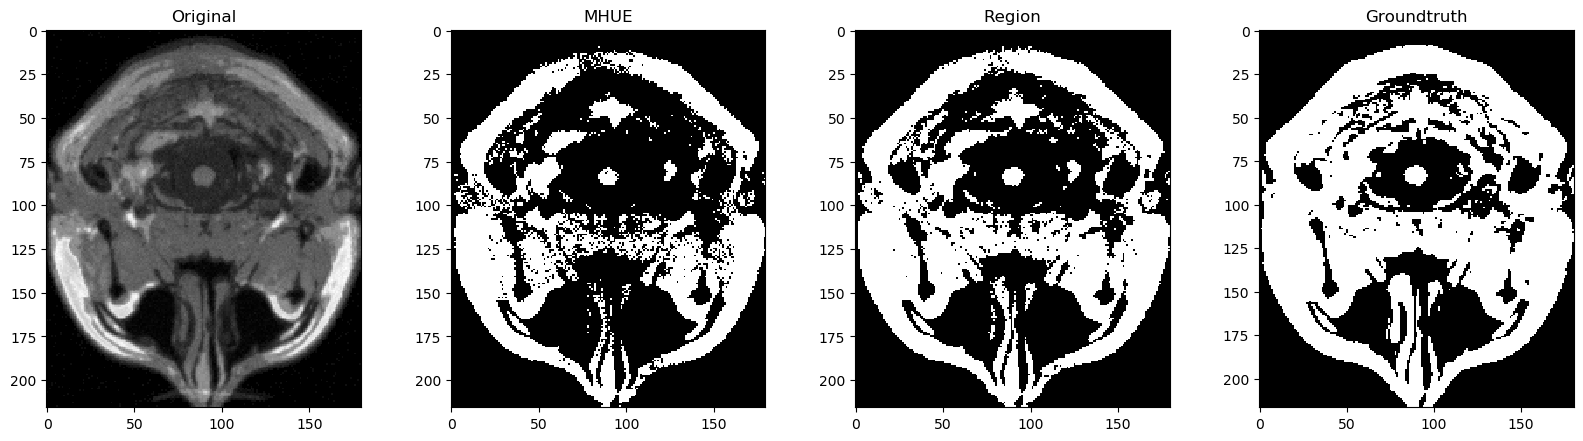

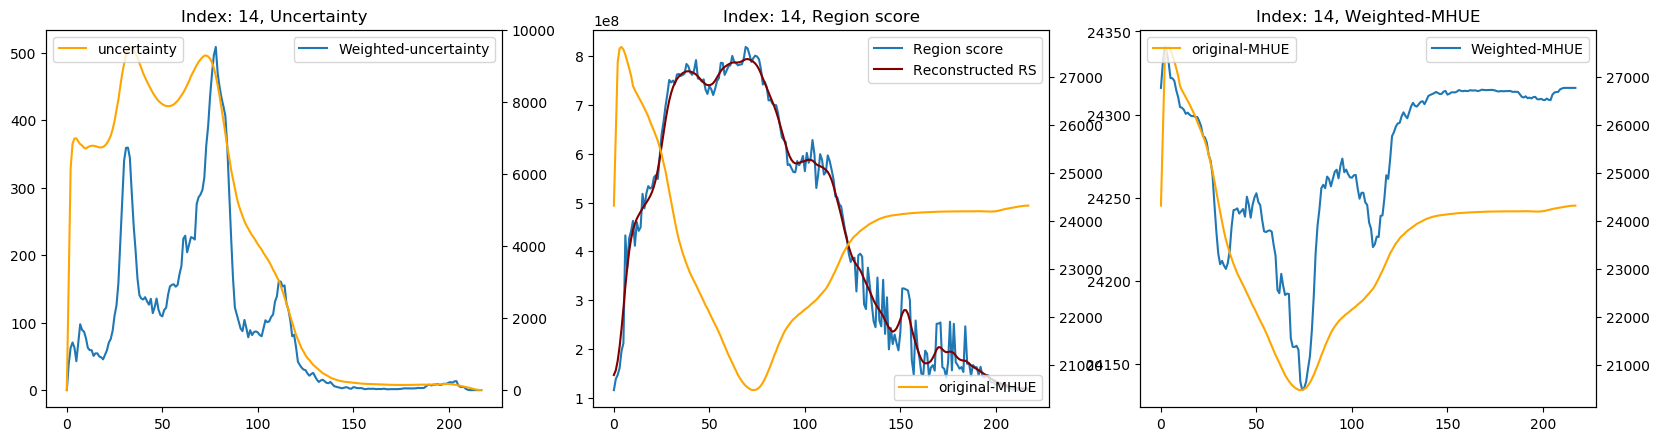

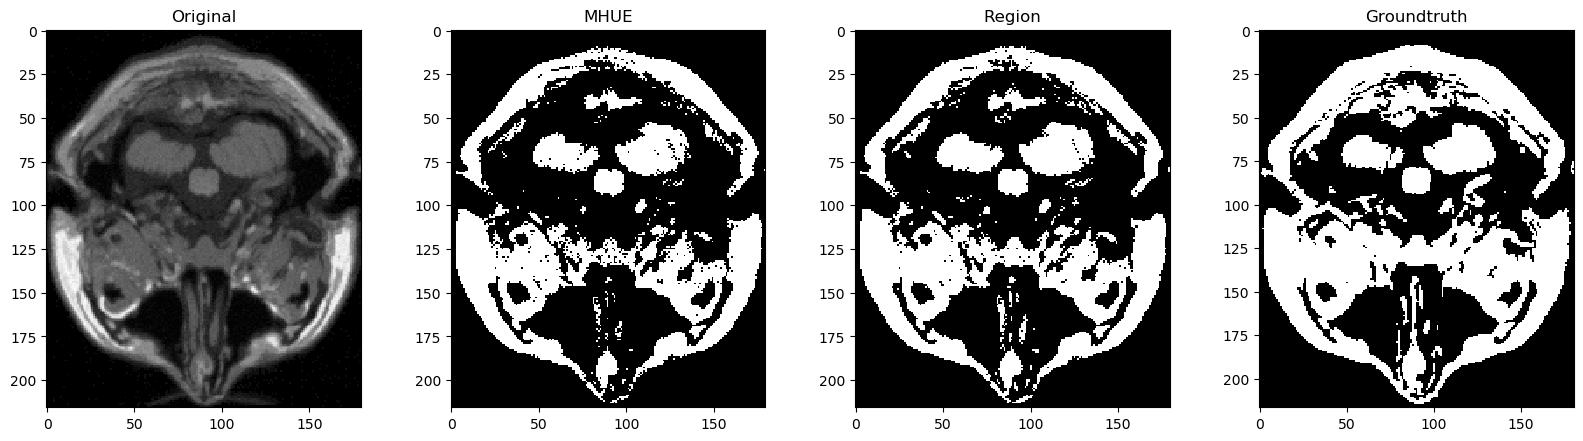

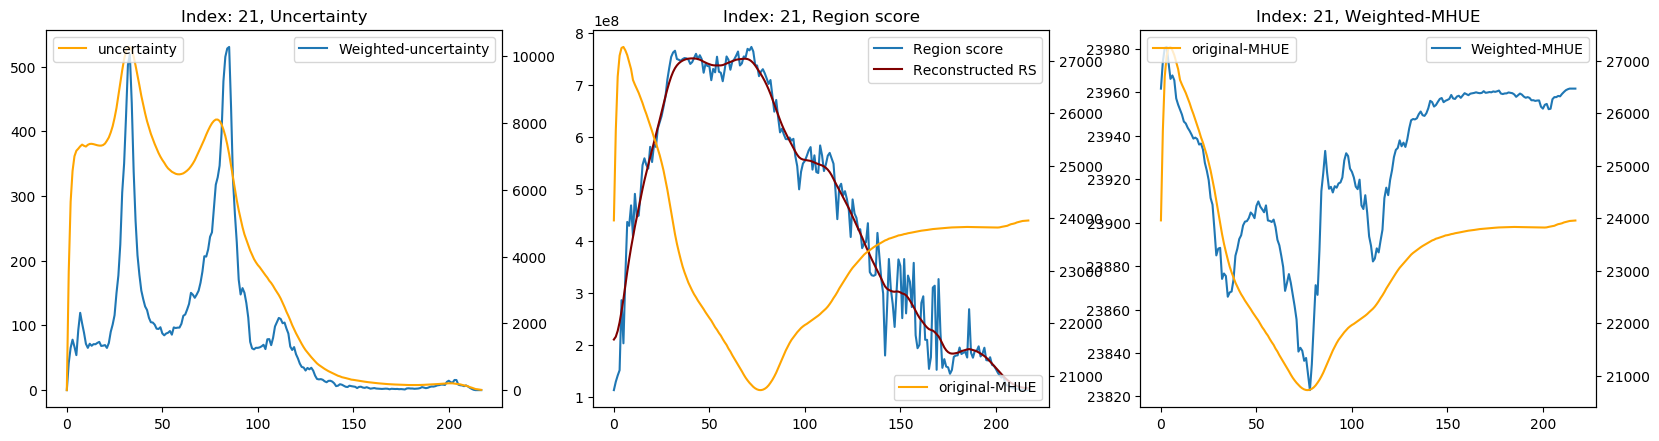

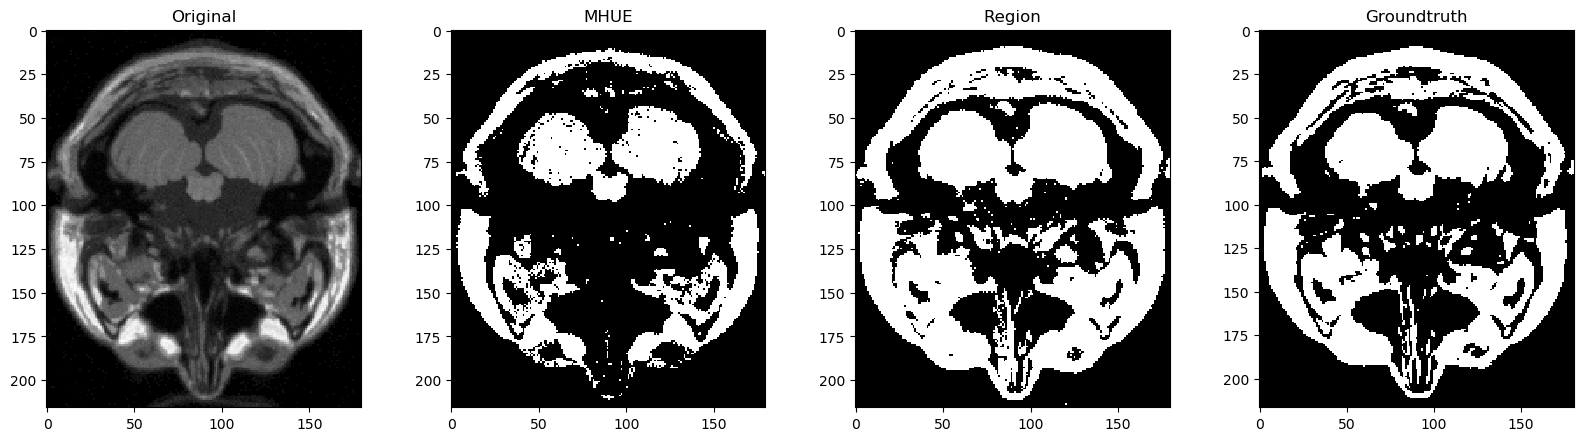

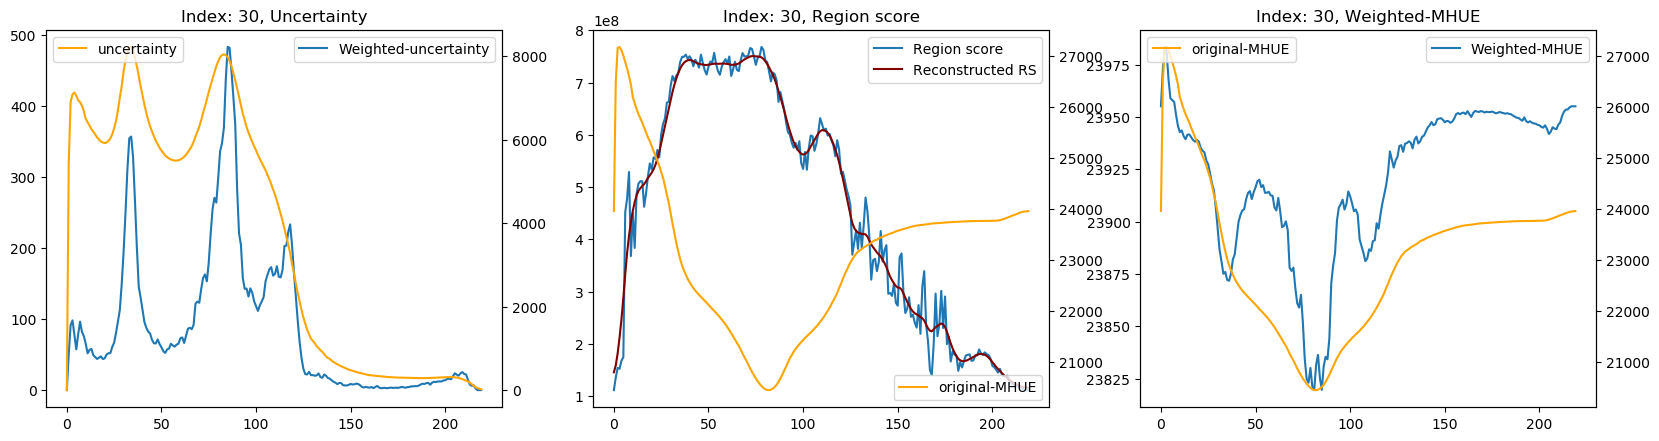

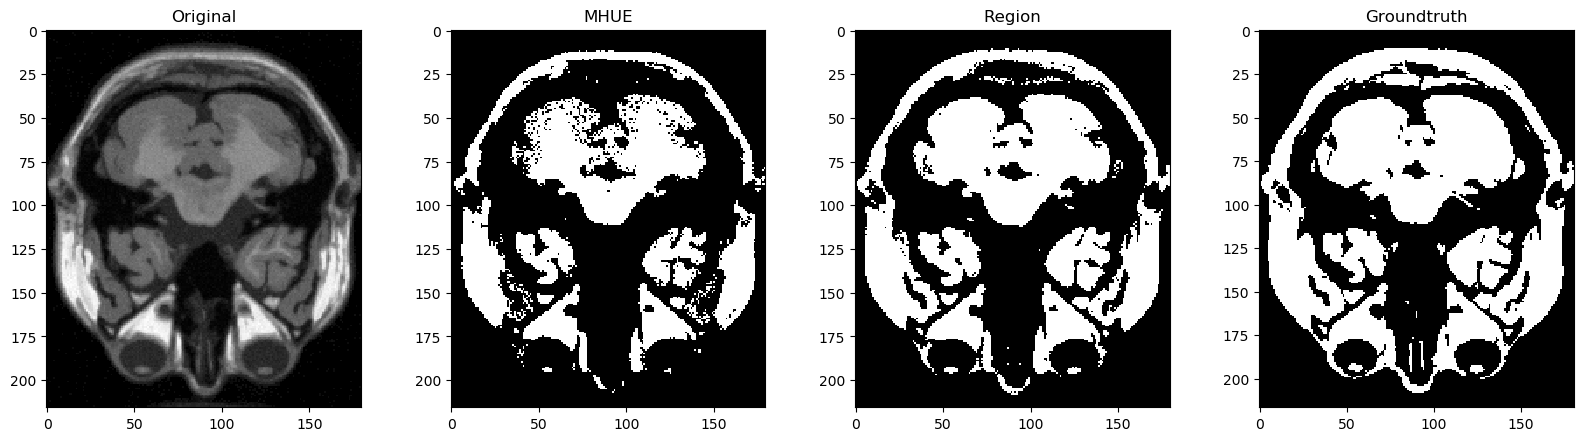

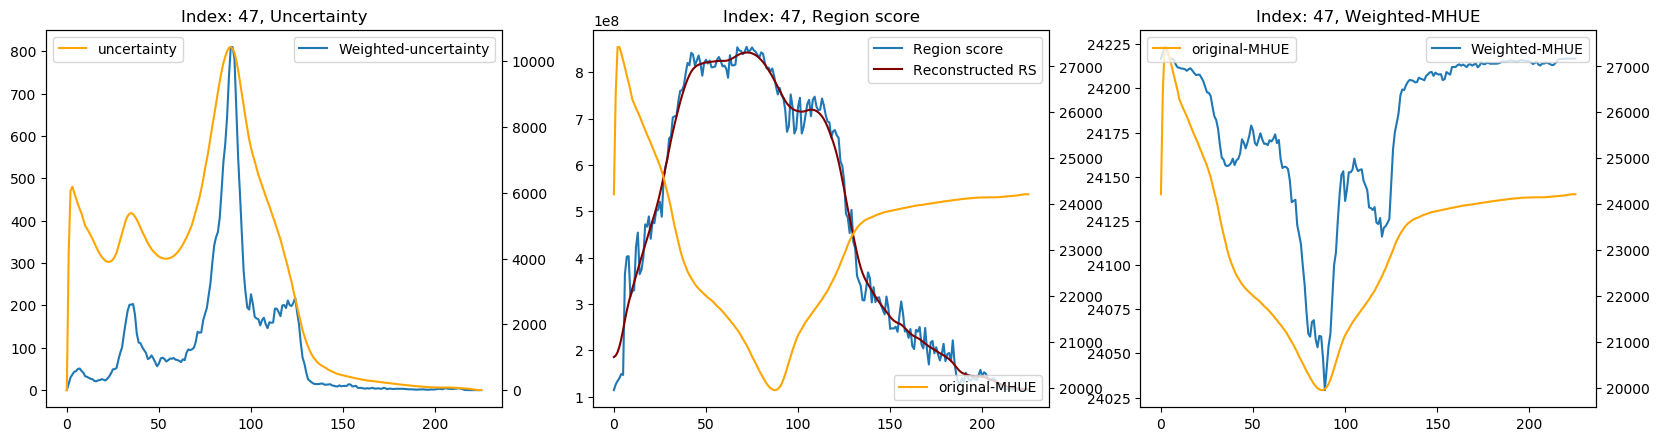

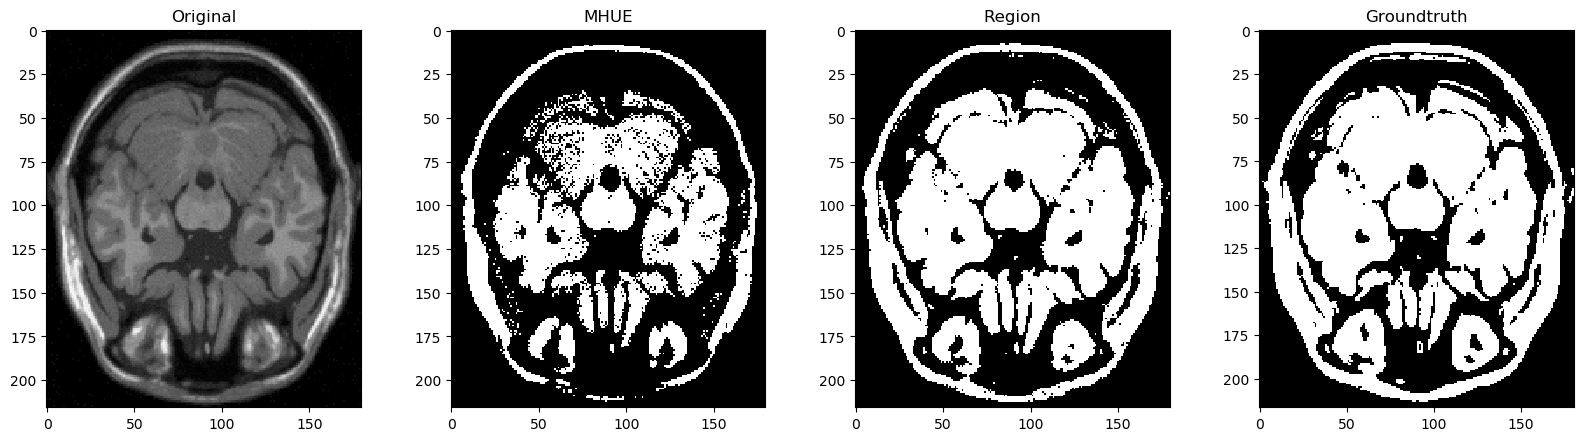

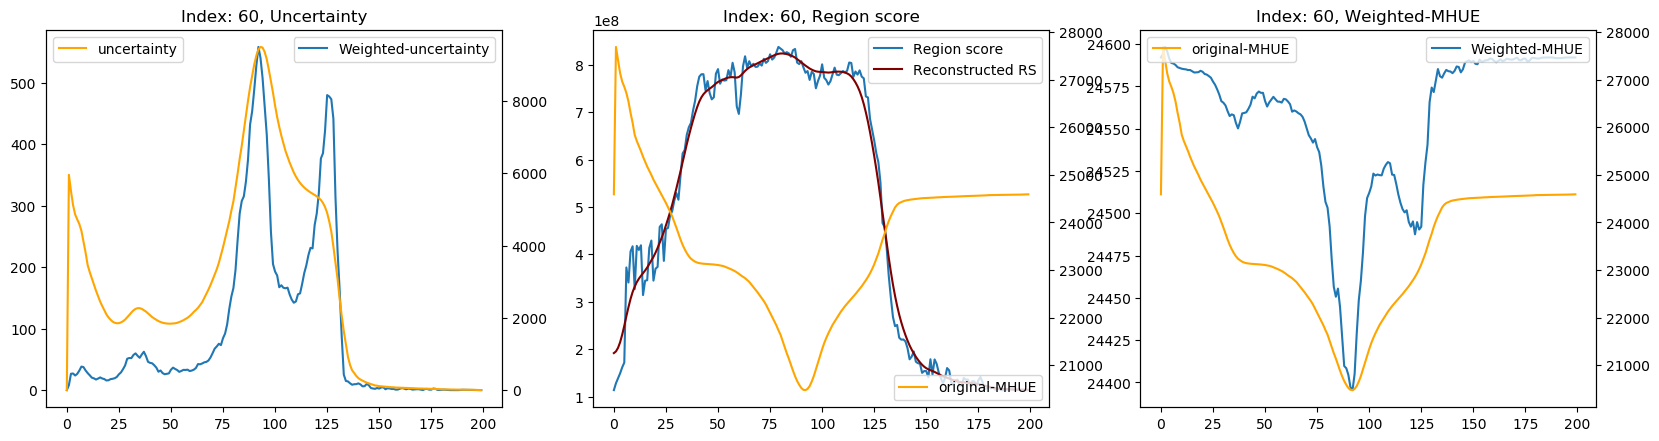

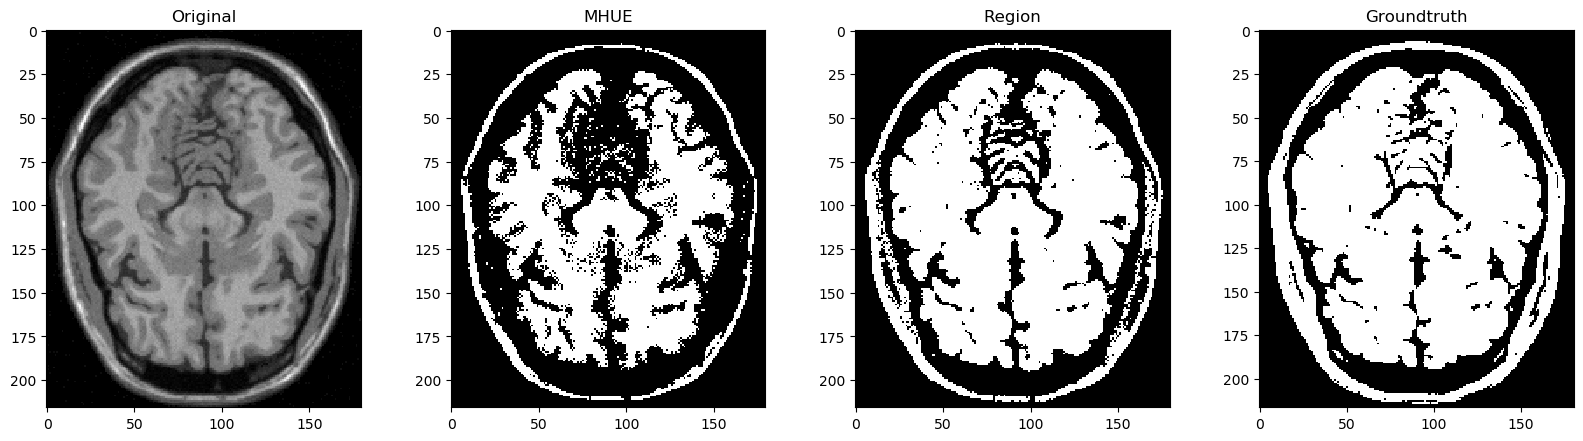

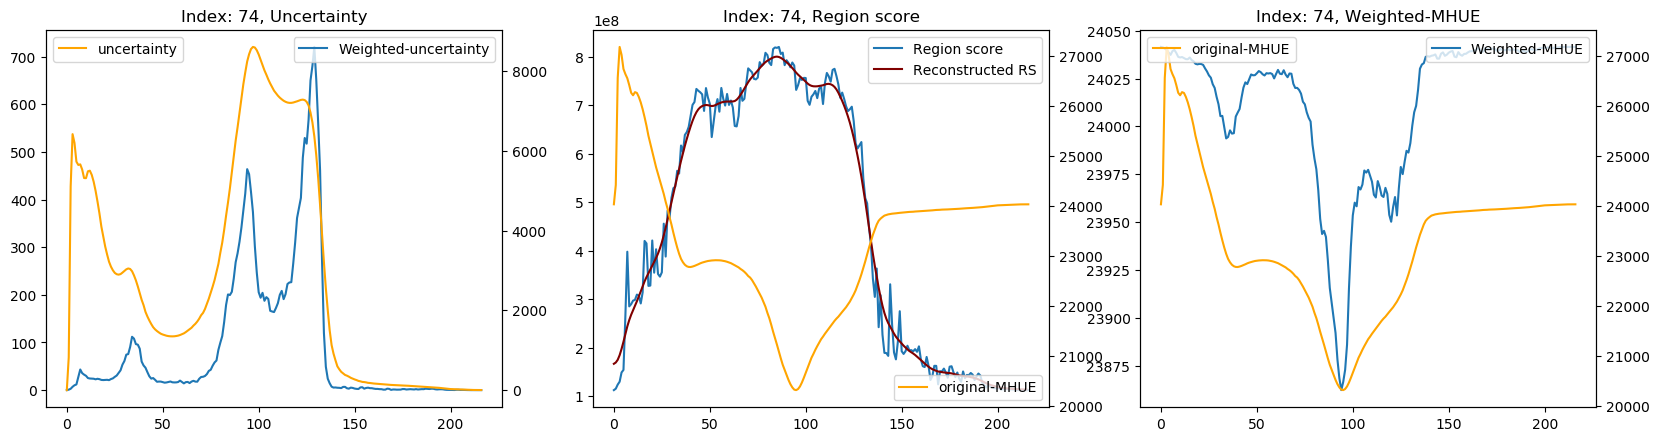

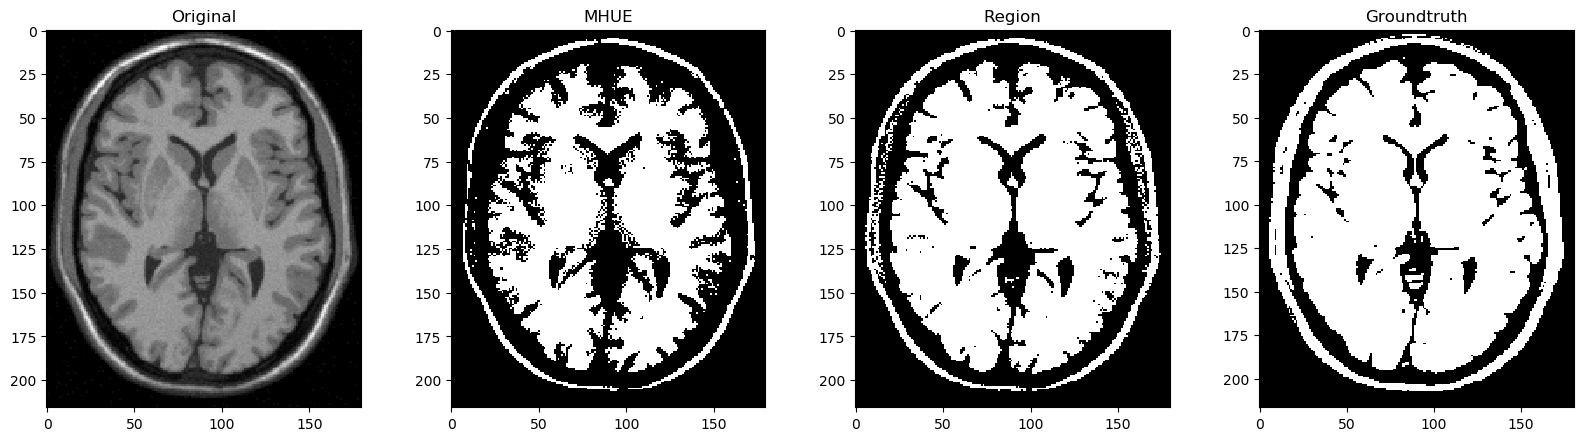

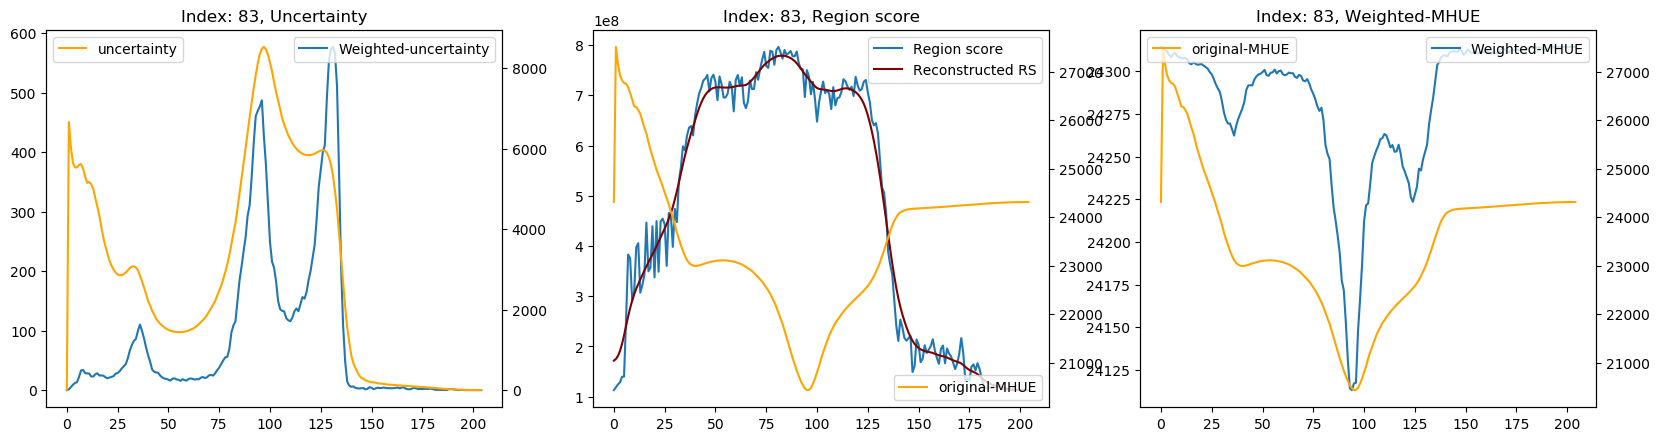

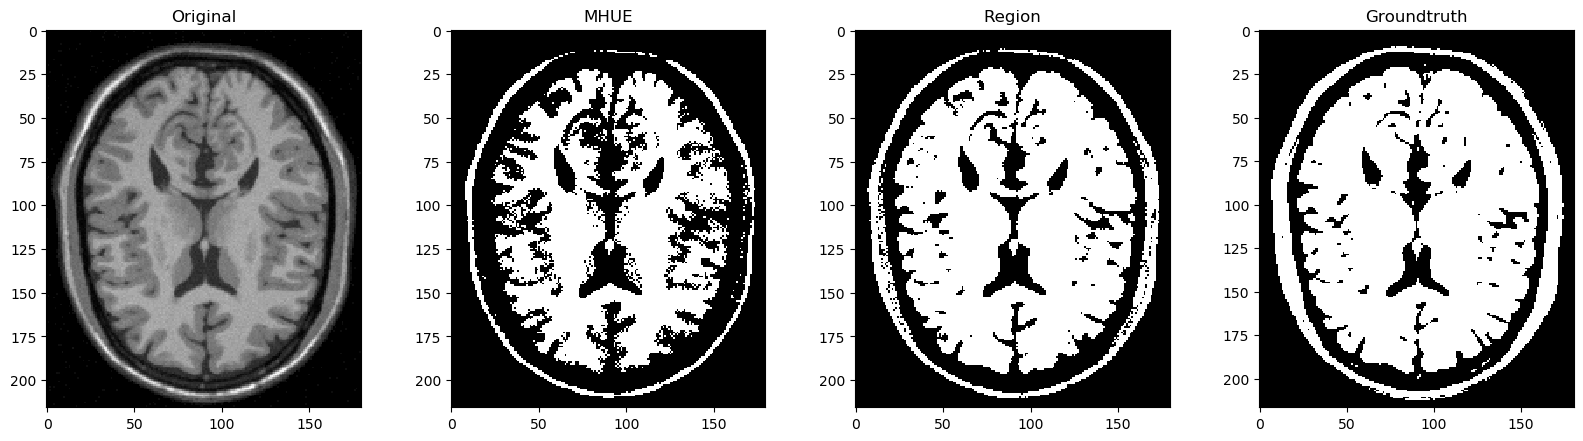

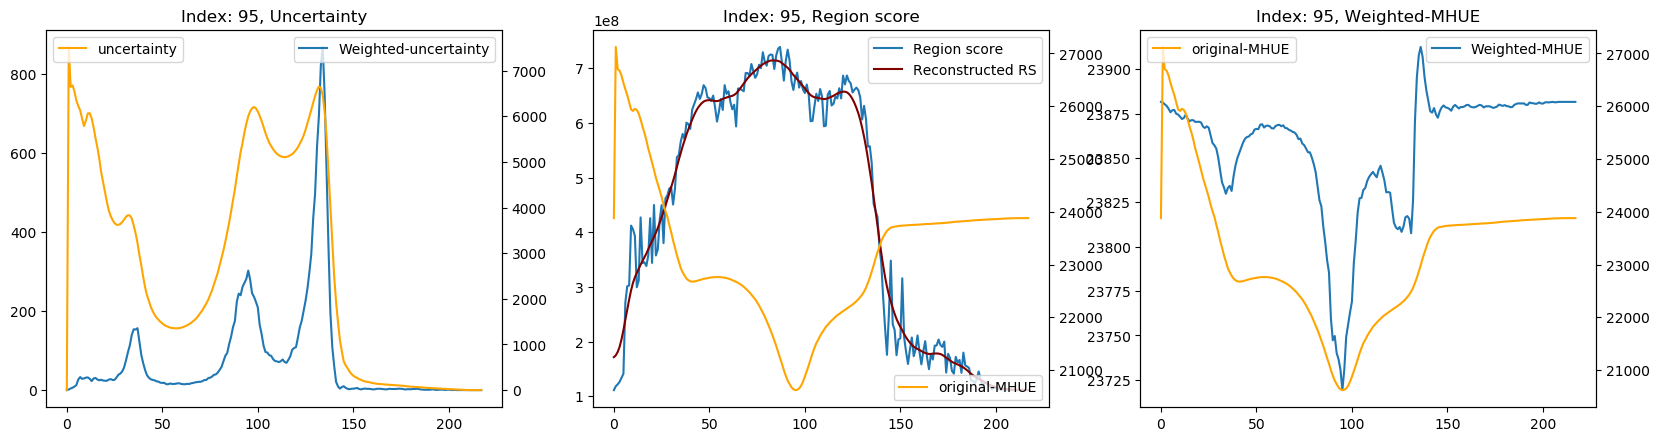

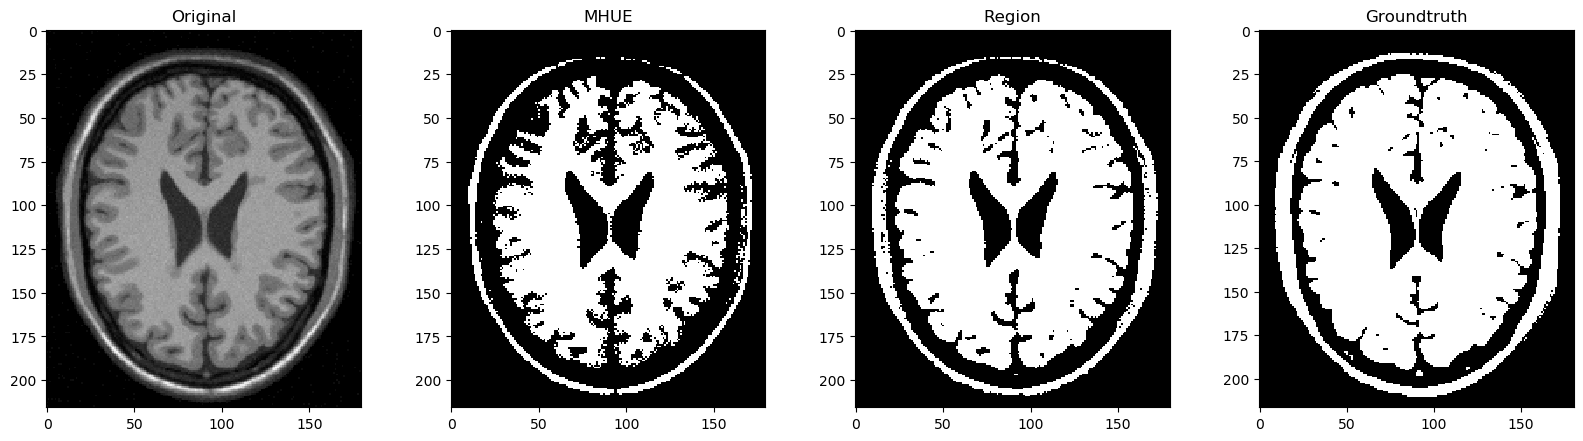

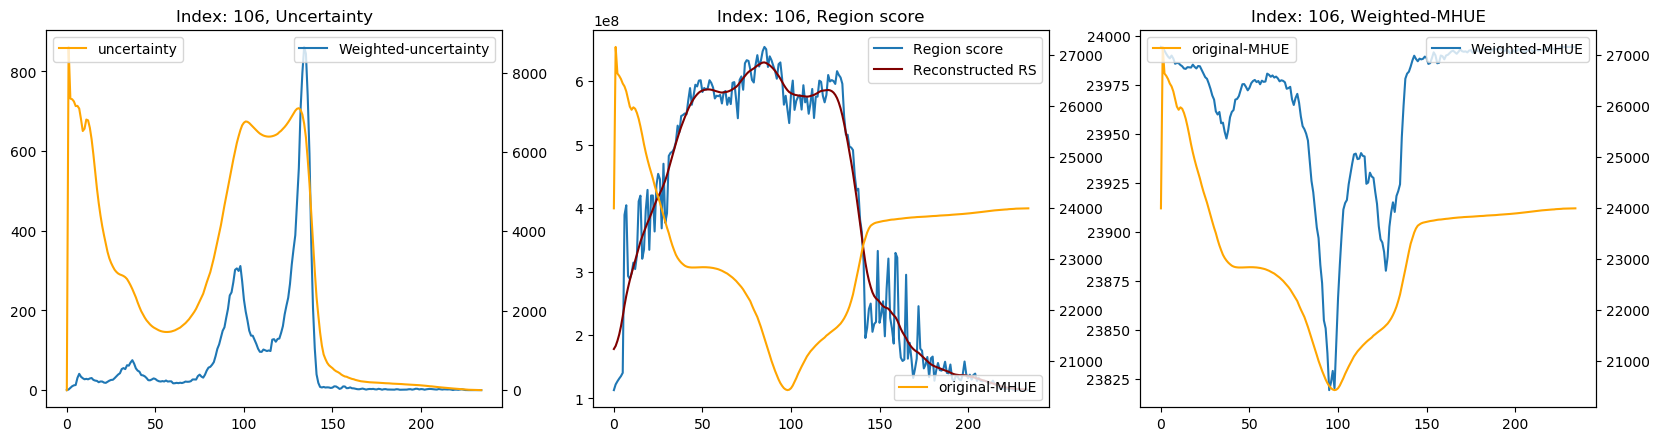

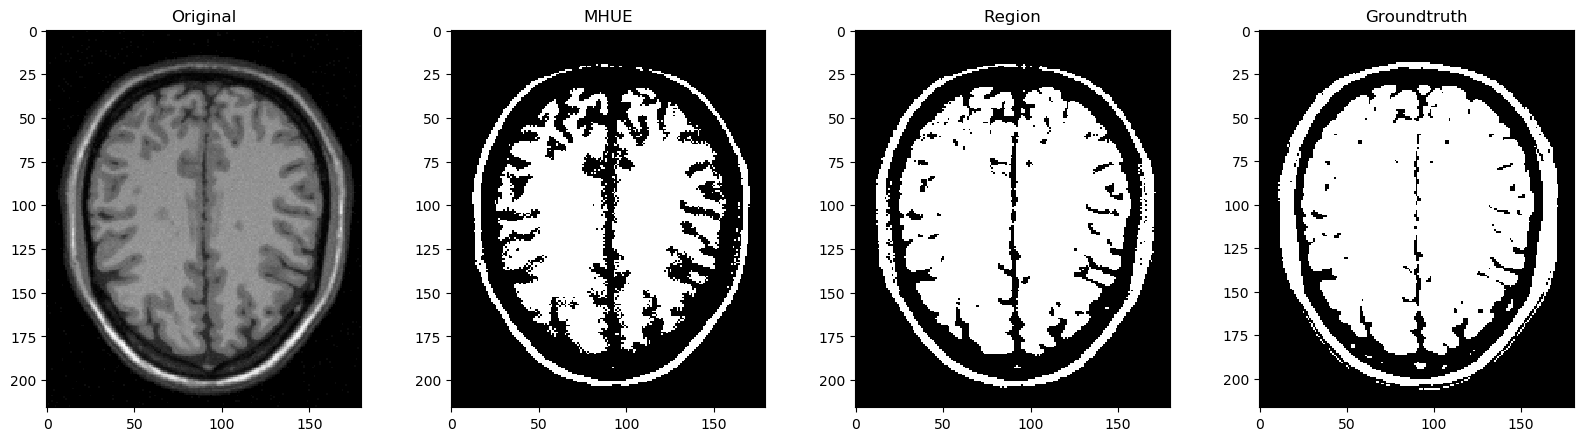

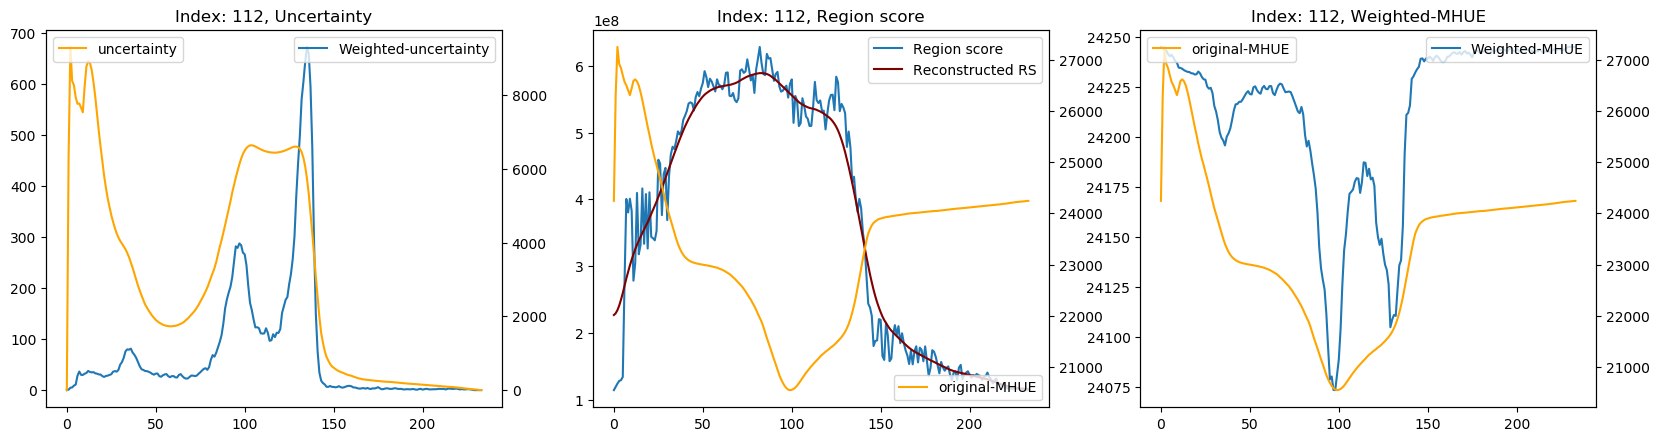

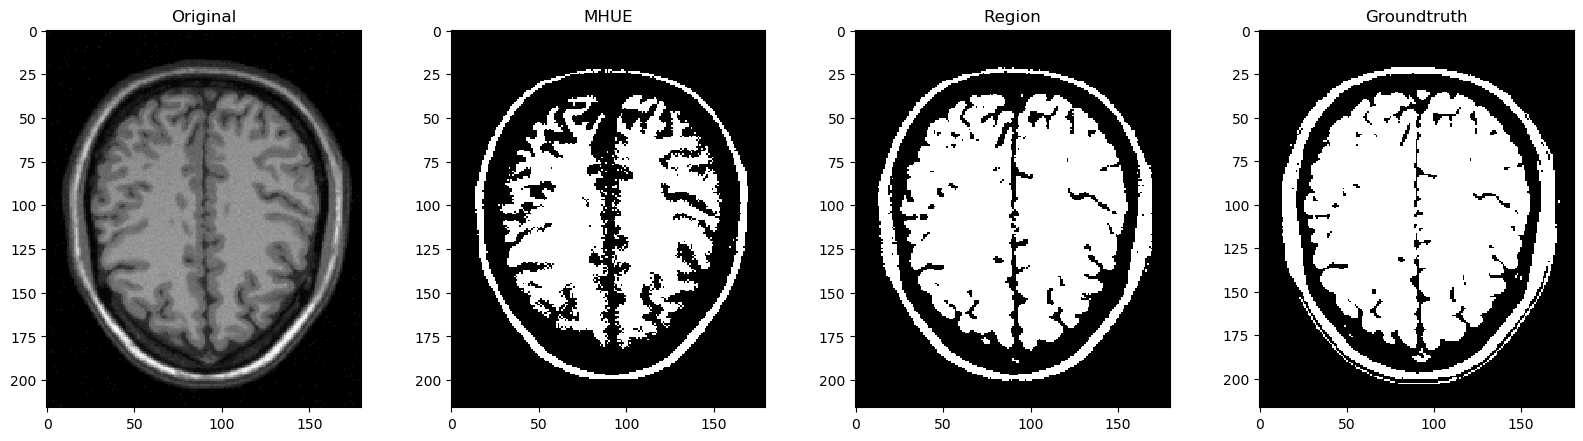

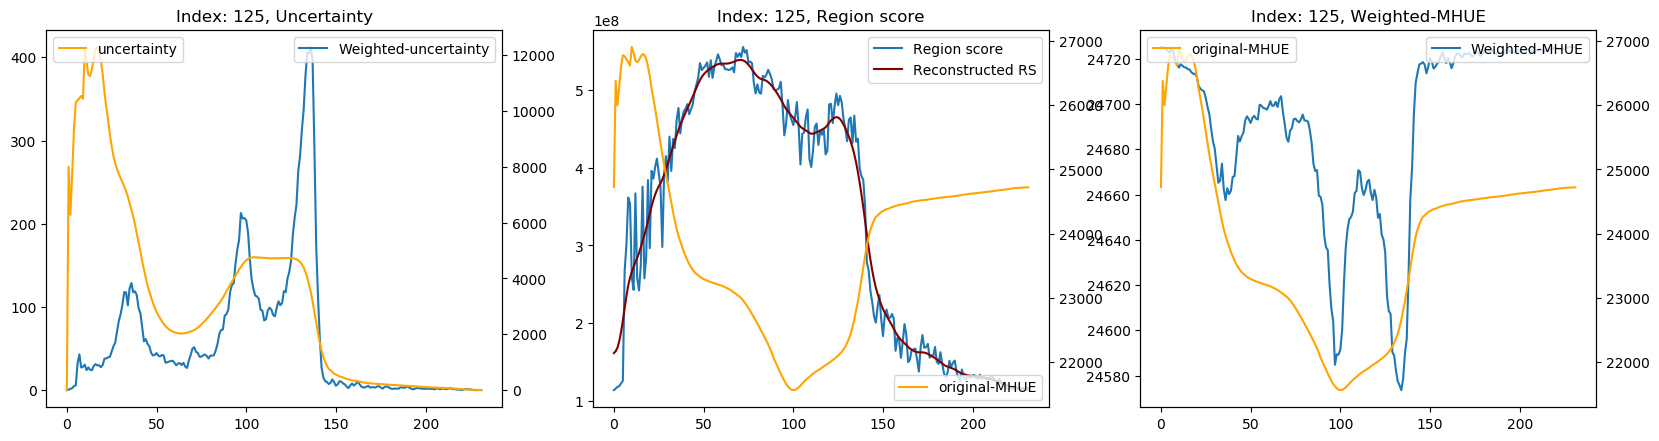

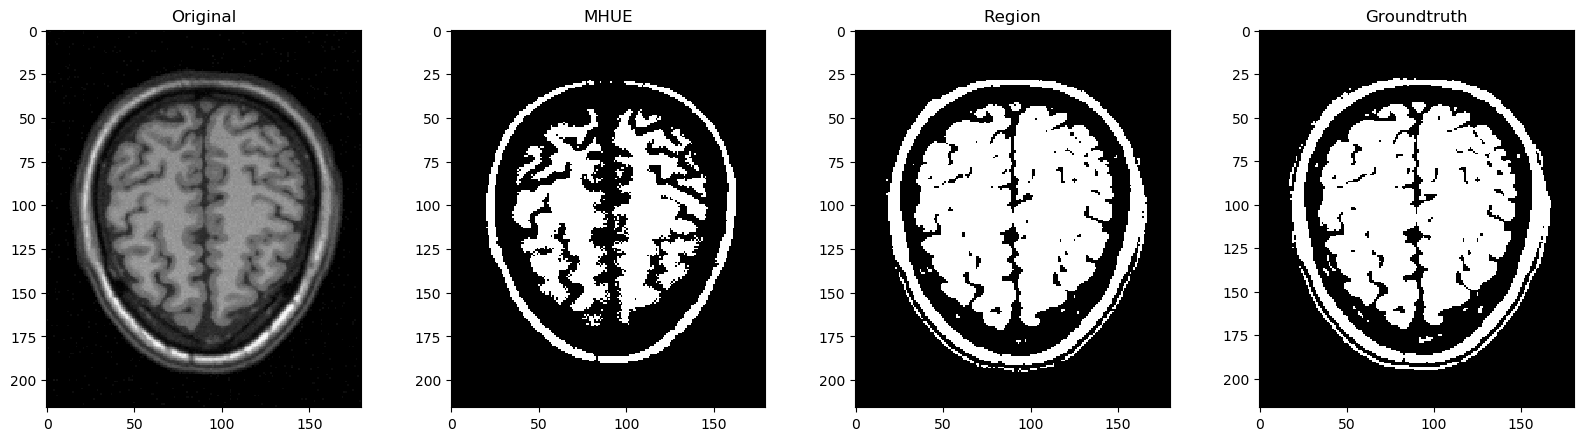

In [15]:
from vmdpy import VMD

for i in range(len(_img)):
    _u = list(map(lambda x:np.sum(x),_uncertainty[i]))
    _uw = list(map(lambda x:np.sum(x),_uncertaintyw[i]))
    _e = list(map(lambda x:np.sum(x),_mhue[i]))
    _ew = list(map(lambda x:np.sum(x),_mhuew[i]))
    _r = list(map(lambda x:np.sum(x),_region[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(131)
    ax2 = ax1.twinx()
    ax1.plot(_uw,label='Weighted-uncertainty')
    ax1.legend(loc=1)
    ax2.plot(_u,color='orange',label='uncertainty')
    ax2.legend(loc=2)
    plt.title('Index: {}, Uncertainty'.format(test_lst[i]))
    
    ax3 = fig.add_subplot(132)
    ax4 = ax3.twinx()
    ax3.plot(_r,label='Region score')
    
    #     alpha = 2000       # moderate bandwidth constraint  
    #     tau = 0.0          # noise-tolerance (no strict fidelity enforcement)  
    #     K = 5              # modes
    #     DC = 0             # no DC part imposed  
    #     init = 1           # initialize omegas uniformly  
    #     tol = 1e-7  

    _r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
    _r_recon = list(_r_recon_all[0,:])
    for mode in range(1,_r_recon_all.shape[0]):
        if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
            _r_recon += _r_recon_all[mode,:]
            
    ax3.plot(_r_recon,color='maroon',label='Reconstructed RS')
    
    ax3.legend(loc='upper right')
    ax4.plot(_e,color='orange',label='original-MHUE')
    ax4.legend(loc=4)
    plt.title('Index: {}, Region score'.format(test_lst[i]))
    
    ax6 = fig.add_subplot(133)
    ax7 = ax6.twinx()
    ax6.plot(_ew,label='Weighted-MHUE')
    ax6.legend(loc=1)
    ax7.plot(_e,color='orange',label='original-MHUE')
    ax7.legend(loc=2)
    plt.title('Index: {}, Weighted-MHUE'.format(test_lst[i]))
    
    plt.savefig('../output/Brainweb_'+str(test_lst[i])+'_1.jpg')
    
    
    tlower = np.min(_img[i]) + 2
    t1 = np.argmin(_e) + tlower
    t2 = np.argmin(_ew) + tlower
    t3 = np.argmax(_r_recon) + tlower
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(141)
    ax1.imshow(_img[i])
    ax1.set_title('Original')
    ax2 = fig.add_subplot(142)
    _,res = cv.threshold(_img[i],t1,255,0)
    ax2.imshow(res)
    ax2.set_title('MHUE')
#     ax3 = fig.add_subplot(143)
#     _,tmp = cv.threshold(_img[i],t2,255,0)
#     ax3.imshow(tmp)
#     ax3.set_title('Weighted-MHUE')
    ax3 = fig.add_subplot(143)
    _,tmp = cv.threshold(_img[i],t3,255,0)
    ax3.imshow(tmp)
    ax3.set_title('Region')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(_groundtruth[i])
    ax4.set_title('Groundtruth')
    
    plt.show()
#     plt.savefig('../output/Brainweb_'+str(test_lst[i])+'_2.jpg')
    plt.close()
    


## Off-centered Entropy (OCE)

$$
\eta(p) = -\pi\log(\pi) - (1-\pi)\log(1-\pi)
$$

where $\pi = \frac{p}{2w}$ if $0\leq p \leq w$ and $\pi = \frac{p+1-2w}{2(1-w)}$ if $w \leq p \leq 1$

Here we set $(w,1-w)$ the prior imbalanced distribution (Mino/Majo rate)

## Context-based Entropy (Weighted Information Entropy, IEW)

> Suppose you
learn a news about severe weather conditions in an area far away from your place.
Such conditions usually do not happen; an event like this has a small probability
and conveys a high information. At the same time you hear that a tree
near your parking lot in the town has fallen and damaged a number of cars. The probability
of this event is also low, so the amount of information is again high. However,
the value of this information for you is higher than in the first event.

$$
IEW_t=-\sum_i \phi(x_{i,t})p(x_{i,t})\log p(x_{i,t})
$$

where a non-negative *weight function* $x_{i,t} \rightarrow \phi (x_{i,t})$ is introduced, representing a value/utility of an outcome $x_{i,t}$

Here we set $\phi$ as: (pixels with larger stability and smaller BDT are of higher value)

$$
\phi(x_{i,t}) = \frac{stab(t) / D_t}{\sum_t stab(t) / D_t}
$$

$$
D_t = \frac{BDT(x_{i,t})}{\sum_i BDT(x_{i,t})}
$$

```
def get_weights(stab_ema, bdts):
    weights = []
    denominator = 0
    for t in range(len(bdts)):
        Dct = bdts[t] / np.sum(bdts[t])
        weights.append(stab_ema[t] / Dct)
        denominator += (stab_ema[t] / Dct)
    weights /= denominator
    return min_max(weights)
```


## Feasible Edge Measure

**Target: Clean and explicit edge**

Measure the sum of $D(x_i)$ for $x_i$ which have non-zero uncertainty.

Select: `where(_u!=0)`, denote points set $U$

$$
\sum_{x_i\in U}\frac{u(x_i)\cdot (D_o(x_i)+D_b(x_i))}{|U|}
$$

Select: `where(bdt_o_idx!=-1)` i.e.$x_i\in O$

$$
\frac{\sum_{x_i\in O}\phi_t (x_i)}{|x_i\in O|}
$$


In [48]:
img = cv.imread('../t1/outImg5.bmp',0)
_,mask = cv.threshold(img,10,255,0)
mask = binary_fill_holes(mask)
img = img*mask
img = crop_image(img)
scharr = homogeneity.get_scharr(img)
scharr = homogeneity.rank_normalize(scharr)

Get Scharr gradient value, done.
